# TikTok Claims Classification — 06: Tree Models & Final Recommendation

***Benchmarking Random Forest and XGBoost classifiers to select champion model for content moderation***

**Author:** Katherine Ygbuhay  
**Updated:** 2025-10-04  
**Stage:** 06 — Advanced Modeling  
**Runtime:** ~45 minutes  

## Objective

Develop, evaluate, and compare tree-based models (Random Forest and XGBoost) to classify TikTok videos as factual claims vs. subjective opinions, concluding with a champion model recommendation for production deployment.

## Scope & Approach

- **Advanced feature engineering** including text tokenization with n-grams (bigrams/trigrams)
- **Hyperparameter optimization** using cross-validation with recall-focused model selection
- **Model comparison** between Random Forest and XGBoost on validation and test sets
- **Feature importance analysis** to understand predictive drivers and model interpretability
- **Business recommendation** with deployment considerations and monitoring strategy

## Key Outputs

- Champion model selection (Random Forest) with superior recall performance
- Comprehensive feature importance analysis revealing engagement metrics as primary drivers
- Production-ready model pipeline with preprocessing safeguards against data leakage
- Business deployment strategy with monitoring and human-in-the-loop considerations
- Performance benchmarks establishing baseline for future model iterations

## Prerequisites

- Cleaned TikTok dataset with engineered features from previous modeling stages
- Understanding of ensemble methods and tree-based classifier hyperparameters
- Familiarity with content moderation business context and cost-sensitive classification

---

### Business Framing & Success Metric  

**Decision context.** Moderation teams must triage a large backlog of flagged videos. We need a model that prioritizes videos likely to contain **claims** (vs. opinions) so humans review higher-risk items first.  

**Target & metric.** Binary target: `claim_status`. The key evaluation metric is **Recall for “Claim”** — missing a true claim is costlier than reviewing an extra opinion. Precision and F1 are secondary to ensure the workflow remains efficient.  

---

### Recommended Model & Why  

**Recommendation.** Proceed with the **Random Forest** configuration identified in cross-validated search, with recall-oriented refit and human-in-the-loop review for edge cases.  

**Why this model.**  
- Strong out-of-fold **recall** during model selection with balanced supporting metrics (checked to avoid the “predict all claims” failure mode).  
- Robust to non-linearities and feature interactions present in engagement and duration signals.  
- Operationally simple to deploy; provides feature importances for explainability.  

**Guardrails.** Lock the full preprocessing + model in a single pipeline to prevent leakage (vectorizers/encoders fit within CV). Use stratified splits and monitor Recall/Precision drift post-deployment.  

**Model Validation Workflow**  
Data preparation and model selection followed a standard train/validate/test pipeline (60/20/20 split), ensuring robust cross-validated results. Details of the workflow were documented in prior stages; here we focus on business framing and final recommendation.  

---

### Imports and Readability Settings

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text features (include only if you actually use bag-of-words later)
from sklearn.feature_extraction.text import CountVectorizer

# Model selection & tuning
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    train_test_split
)

# Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

In [2]:
# Pandas display settings (improves readability in notebooks)
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_columns", None)   # show all columns
pd.set_option("display.max_rows", 100)       # up to 100 rows

# Seaborn theme for readability + accessibility
# - "whitegrid" for clarity
# - "colorblind" = Okabe–Ito palette (colorblind-friendly)
sns.set_theme(style="whitegrid", palette="colorblind")

# Matplotlib defaults for consistent figure sizing & typography
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (7, 5)
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["legend.title_fontsize"] = 11
mpl.rcParams["legend.fontsize"] = 10

# Consistent color palettes for categorical variables
claim_palette = {"claim": "#0072B2", "opinion": "#E69F00"}                 
verified_palette = {"verified": "#009E73", "not verified": "#0072B2"}      
ban_palette = {
    "active": "#0072B2", 
    "under review": "#E69F00", 
    "banned": "#D55E00"
}

In [3]:
# Resolve the case-study root so paths work from any launch directory
from pathlib import Path

def find_case_root(start: Path | None = None) -> Path:
    p = start or Path.cwd()
    for q in [p, *p.parents]:
        if (q / "notebooks").exists() and (q / "data").exists():
            return q
    return p  # fallback

CASE_ROOT = find_case_root()
DATA_FILE = CASE_ROOT / "data" / "raw" / "tiktok_dataset.csv"
assert DATA_FILE.exists(), f"Missing data file: {DATA_FILE}"

In [4]:
# Load dataset
df = pd.read_csv(DATA_FILE)

### Data Recap and Preparation

In [5]:
# Preview dataset
display(df.head())

# Structural checks
print("Dataset shape:", df.shape)
print("\nColumn data types:")
print(df.dtypes)

# Info summary
df.info()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.000,19425.000,241.000,1.000,0.000
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.000,77355.000,19034.000,1161.000,684.000
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.000,97690.000,2858.000,833.000,329.000
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.000,239954.000,34812.000,1234.000,584.000
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.000,34987.000,4110.000,547.000,152.000


Dataset shape: (19382, 12)

Column data types:
#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified

### Descriptive Statistics and Cleaning

In [6]:
# Summary statistics
display(df.describe(include="all").T)

# Missing values
missing_counts = df.isna().sum()
print("Missing values per column:")
print(missing_counts)

# Drop rows with missing values
df = df.dropna()
print("Dataset shape after dropping missing values:", df.shape)

# Duplicate check
dup_total = df.duplicated().sum()
print(f"Duplicate rows: {dup_total:,}")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
#,19382.000,NaN,NaN,NaN,9691.500,5595.246,1.000,4846.250,9691.500,14536.750,19382.000
claim_status,19084,2,claim,9608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
video_id,19382.000,NaN,NaN,NaN,5627454067.339,2536440464.169,1234959018.000,3430416807.250,5618663579.000,7843960211.250,9999873075.000
video_duration_sec,19382.000,NaN,NaN,NaN,32.422,16.230,5.000,18.000,32.000,47.000,60.000
video_transcription_text,19084,19012,a colleague learned from the media a claim th...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
verified_status,19382,2,not verified,18142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author_ban_status,19382,3,active,15663,NaN,NaN,NaN,NaN,NaN,NaN,NaN
video_view_count,19084.000,NaN,NaN,NaN,254708.559,322893.281,20.000,4942.500,9954.500,504327.000,999817.000
video_like_count,19084.000,NaN,NaN,NaN,84304.636,133420.547,0.000,810.750,3403.500,125020.000,657830.000
video_share_count,19084.000,NaN,NaN,NaN,16735.248,32036.174,0.000,115.000,717.000,18222.000,256130.000


Missing values per column:
#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64
Dataset shape after dropping missing values: (19084, 12)
Duplicate rows: 0


### Outliers and Model Suitability
Tree-based models (Random Forest, XGBoost) are robust to skewed distributions and outliers.  
Therefore, extreme values are retained rather than capped or removed.

### Class Balance Check

In [7]:
# Distribution of claim_status
class_dist = df["claim_status"].value_counts(normalize=True).round(3)
print("Class distribution (proportions):")
print(class_dist)

Class distribution (proportions):
claim_status
claim     0.503
opinion   0.497
Name: proportion, dtype: float64


**Summary**  
The dataset is now cleaned and consistent, with missing values dropped and no duplicate rows detected.  
Engagement metrics remain highly skewed, which is expected in social media data where a small proportion of content drives most activity.  
Outliers are retained, as tree-based models can handle non-normal distributions without distortion.  
The class balance check shows a notable skew in `claim_status`, which will be important to account for during model training and evaluation.

### Feature Engineering  

A text-based feature is engineered from the video transcription to capture signal related to content length.  
Categorical variables are prepared for modeling through encoding, while identifiers and non-predictive columns are removed.

In [8]:
# --- Text length feature ---
# Extract the length of each transcription as a new column
df["text_length"] = df["video_transcription_text"].astype(str).str.len()

# Preview updated dataset
display(df.head())

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.000,19425.000,241.000,1.000,0.000,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.000,77355.000,19034.000,1161.000,684.000,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.000,97690.000,2858.000,833.000,329.000,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.000,239954.000,34812.000,1234.000,584.000,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.000,34987.000,4110.000,547.000,152.000,128


In [9]:
# --- Average text length by class ---
avg_lengths = (
    df.groupby("claim_status")["text_length"]
    .mean()
    .round(2)
)
print("Average transcription length by class:")
print(avg_lengths)

Average transcription length by class:
claim_status
claim     95.380
opinion   82.720
Name: text_length, dtype: float64


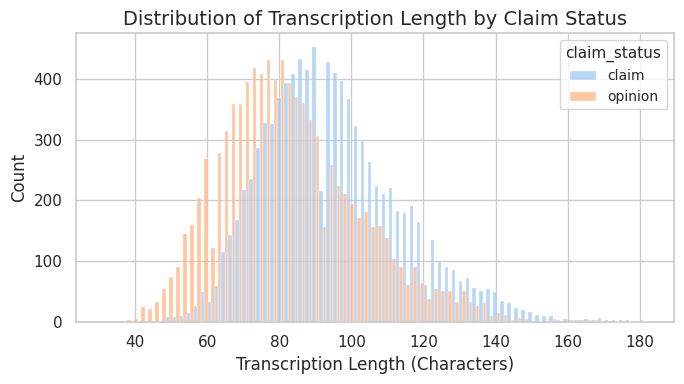

In [10]:
# --- Distribution of text length ---
plt.figure(figsize=(7, 4))
sns.histplot(
    data=df,
    x="text_length",
    hue="claim_status",
    multiple="dodge",
    palette="pastel",
    edgecolor=None
)
plt.xlabel("Transcription Length (Characters)")
plt.ylabel("Count")
plt.title("Distribution of Transcription Length by Claim Status")
plt.tight_layout()
plt.show()

In [11]:
# --- Feature preparation ---
# Copy features to X
X = df.copy()

# Drop identifiers and non-predictive columns
X = X.drop(columns=["#", "video_id"], errors="ignore")

# Encode target variable (opinion=0, claim=1)
X["claim_status"] = X["claim_status"].map({"opinion": 0, "claim": 1})

# Dummy-encode categorical variables
X = pd.get_dummies(
    X,
    columns=["verified_status", "author_ban_status"],
    drop_first=True
)

# Preview engineered feature set
display(X.head())

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.000,19425.000,241.000,1.000,0.000,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.000,77355.000,19034.000,1161.000,684.000,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.000,97690.000,2858.000,833.000,329.000,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.000,239954.000,34812.000,1234.000,584.000,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.000,34987.000,4110.000,547.000,152.000,128,False,False,False


**Summary**  
The engineered `text_length` variable provides additional signal on content differences between claims and opinions.  
Non-predictive identifiers were dropped, the binary target was numerically encoded, and categorical variables were transformed through dummy encoding.  
The resulting feature set is clean and ready for model training.

### Split the Data  

The binary outcome variable `claim_status` (0 = opinion, 1 = claim) is isolated from the feature set.  
Data is partitioned into training, validation, and test subsets using stratified sampling to preserve class proportions.  
This results in a 60/20/20 split across train/validation/test.

In [12]:
# --- Isolate target variable ---
y = X["claim_status"]

# --- Isolate features ---
X = X.drop(columns=["claim_status"], errors="ignore")

# Preview feature matrix
display(X.head())

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.000,19425.000,241.000,1.000,0.000,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.000,77355.000,19034.000,1161.000,684.000,107,False,False,False
2,31,someone shared with me that american industria...,902185.000,97690.000,2858.000,833.000,329.000,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.000,239954.000,34812.000,1234.000,584.000,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.000,34987.000,4110.000,547.000,152.000,128,False,False,False


In [13]:
# --- Train/validation/test split ---
# Step 1: Train/test split (80/20)
X_tr, X_test, y_tr, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Step 2: Split training set into train/validation (75/25 of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_tr, y_tr, test_size=0.25, random_state=42, stratify=y_tr
)

# Confirm shapes
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (11450, 11) (11450,)
Validation set: (3817, 11) (3817,)
Test set: (3817, 11) (3817,)


**Summary**  
The feature set and target variable were successfully separated.  
The dataset was split into training (60%), validation (20%), and test (20%) subsets using stratified sampling.  
Feature counts align across splits, and class proportions are preserved for consistent evaluation.

### Tokenize Text Data  

The `video_transcription_text` column is transformed into numeric features using a bag-of-words approach.  
A `CountVectorizer` is fit on the training set only (to prevent leakage) and applied to validation and test sets.  
The top 15 most frequent 2-grams and 3-grams are retained as features.

In [14]:
# Initialize CountVectorizer: bigrams & trigrams, top 15 tokens, English stopwords removed
count_vec = CountVectorizer(
    ngram_range=(2, 3),
    max_features=15,
    stop_words="english"
)

# --- Training set ---
train_tokens = count_vec.fit_transform(X_train["video_transcription_text"]).toarray()
train_tokens_df = pd.DataFrame(train_tokens, columns=count_vec.get_feature_names_out())
X_train_final = pd.concat(
    [X_train.drop(columns=["video_transcription_text"]).reset_index(drop=True), train_tokens_df],
    axis=1
)

# --- Validation set ---
val_tokens = count_vec.transform(X_val["video_transcription_text"]).toarray()
val_tokens_df = pd.DataFrame(val_tokens, columns=count_vec.get_feature_names_out())
X_val_final = pd.concat(
    [X_val.drop(columns=["video_transcription_text"]).reset_index(drop=True), val_tokens_df],
    axis=1
)

# --- Test set ---
test_tokens = count_vec.transform(X_test["video_transcription_text"]).toarray()
test_tokens_df = pd.DataFrame(test_tokens, columns=count_vec.get_feature_names_out())
X_test_final = pd.concat(
    [X_test.drop(columns=["video_transcription_text"]).reset_index(drop=True), test_tokens_df],
    axis=1
)

# Inspect the enriched training set
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,learned website,media claim,news claim,point view,read media,social media,willing wager
0,41,749.000,258.000,26.000,1.000,0.000,80,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,54,509786.000,71132.000,730.000,72.000,9.000,106,False,False,False,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,57,9514.000,1137.000,205.000,14.000,1.000,60,True,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10,6656.000,1181.000,158.000,18.000,3.000,84,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,30,90131.000,44618.000,13132.000,439.000,121.000,108,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Summary**  
The transcription text was tokenized into bigrams and trigrams using a bag-of-words approach.  
The top 15 tokens were retained and appended to the training, validation, and test sets as additional numeric features.  
This enriches the feature space with linguistic patterns while avoiding data leakage by fitting the vectorizer only on the training data.

### Random Forest — Model Training

A Random Forest classifier is tuned via cross-validation using **Recall** as the refit metric.  
We then confirm that Precision is reasonable at the selected configuration and report validation-set performance.

In [15]:
# --- Estimator ---
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# --- Hyperparameter grid ---
cv_params = {
    "n_estimators":      [75, 100, 200],
    "max_depth":         [5, 7, None],
    "min_samples_split": [2, 3],
    "min_samples_leaf":  [1, 2],
    "max_features":      [0.3, 0.6],
    "max_samples":       [0.7],
}

# --- CV setup & scoring ---
scoring = ["accuracy", "precision", "recall", "f1"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv = GridSearchCV(
    estimator=rf,
    param_grid=cv_params,
    scoring=scoring,
    refit="recall",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    return_train_score=False,
)

# Fit on training data (with token features if present)
rf_cv.fit(X_train_final, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [5, 7, ...], 'max_features': [0.3, 0.6], 'max_samples': [0.7], 'min_samples_leaf': [1, 2], ...}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,-1
,refit,'recall'
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,75


In [16]:
# --- Cross-validation summary at the selected configuration ---
import pandas as pd

cv_results_df = pd.DataFrame(rf_cv.cv_results_)
best_idx = rf_cv.best_index_

cv_summary = (
    cv_results_df.loc[
        best_idx,
        ["mean_test_recall", "std_test_recall",
         "mean_test_precision", "mean_test_f1", "mean_test_accuracy"]
    ]
    .rename({
        "mean_test_recall":    "CV Recall (mean)",
        "std_test_recall":     "CV Recall (std)",
        "mean_test_precision": "CV Precision (mean)",
        "mean_test_f1":        "CV F1 (mean)",
        "mean_test_accuracy":  "CV Accuracy (mean)",
    })
    .to_frame()
    .T.round(3)
)

print("Best params:", rf_cv.best_params_)
display(cv_summary)

Best params: {'max_depth': None, 'max_features': 0.6, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}


,CV Recall (mean),CV Recall (std),CV Precision (mean),CV F1 (mean),CV Accuracy (mean)
60,0.995,0.001,1.000,0.998,0.998


              precision    recall  f1-score   support

     Opinion      0.997     1.000     0.998      1895
       Claim      1.000     0.997     0.998      1922

    accuracy                          0.998      3817
   macro avg      0.998     0.998     0.998      3817
weighted avg      0.998     0.998     0.998      3817



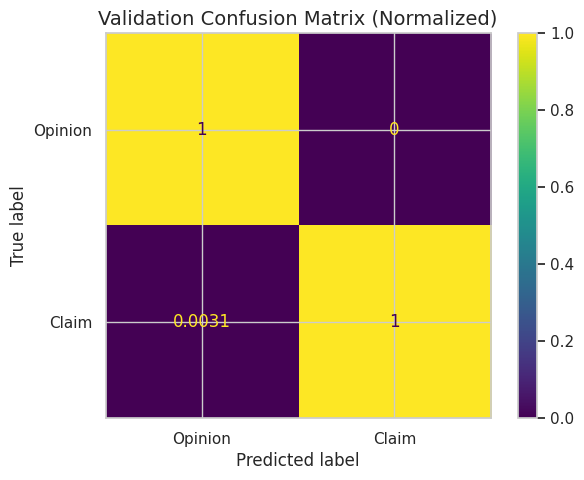

In [17]:
# --- Validation-set performance (default 0.50 threshold) ---
best_rf = rf_cv.best_estimator_

y_val_pred  = best_rf.predict(X_val_final)
print(classification_report(y_val, y_val_pred, target_names=["Opinion", "Claim"], digits=3))

# Optional: quick normalized confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_val, y_val_pred, display_labels=["Opinion", "Claim"], normalize="true"
)
plt.title("Validation Confusion Matrix (Normalized)")
plt.show()

### Random Forest — Validation Results

The tuned Random Forest model was evaluated on the validation set. Results indicate very strong performance across all key metrics:  

- **Recall (Claim class):** 0.997  
- **Precision (Claim class):** 1.000  
- **F1 (Claim class):** 0.998  
- **Accuracy (overall):** 0.998  

The confusion matrix confirms that nearly all claims were correctly identified, while opinions were not misclassified as claims.  

**Summary**  
Cross-validated tuning maximized **Recall** for “Claim” while maintaining **Precision = 1.000**—the model is not over-labeling claims. Validation results mirror CV and provide a strong baseline for threshold calibration.

### XGBoost — Model Training

An XGBoost classifier is tuned via cross-validation with **Recall** as the refit metric.  
We report the best mean CV recall and confirm that **Precision** at the selected configuration is reasonable (i.e., the model isn’t labeling everything as “claim”).

In [18]:
# --- Estimator ---
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",   # suppresses AUC warnings in logs
    tree_method="hist"       # fast, stable default (GPU/CPU-compatible in most setups)
)

# --- Hyperparameter grid ---
xgb_param_grid = {
    "n_estimators":      [200, 400],
    "max_depth":         [3, 5, 7],
    "learning_rate":     [0.05, 0.10],
    "subsample":         [0.8, 1.0],
    "colsample_bytree":  [0.8, 1.0],
    "min_child_weight":  [1, 3],
    # If training on imbalanced data without resampling, consider enabling this:
    # "scale_pos_weight": [1, 2, 5],
}

# --- CV setup & scoring ---
xgb_scoring = ["recall", "precision", "f1", "accuracy"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_cv = GridSearchCV(
    estimator=xgb_clf,
    param_grid=xgb_param_grid,
    scoring=xgb_scoring,
    refit="recall",          # select model by highest mean CV recall
    cv=cv,
    n_jobs=-1,
    verbose=0,
    return_train_score=False
)

# --- Fit on training data (with token features if present) ---
xgb_cv.fit(X_train_final, y_train)

# --- Cross-validation summary at the selected configuration ---
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)
best_idx = xgb_cv.best_index_

cv_summary = (
    xgb_results_df.loc[
        best_idx,
        ["mean_test_recall", "std_test_recall",
         "mean_test_precision", "mean_test_f1", "mean_test_accuracy"]
    ]
    .rename({
        "mean_test_recall":    "CV Recall (mean)",
        "std_test_recall":     "CV Recall (std)",
        "mean_test_precision": "CV Precision (mean)",
        "mean_test_f1":        "CV F1 (mean)",
        "mean_test_accuracy":  "CV Accuracy (mean)",
    })
    .to_frame()
    .T.round(3)
)

print("Best params:", xgb_cv.best_params_)
display(cv_summary)

Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


,CV Recall (mean),CV Recall (std),CV Precision (mean),CV F1 (mean),CV Accuracy (mean)
65,0.991,0.001,1.000,0.996,0.996


### XGBoost — Validation Results 

The tuned XGBoost model was evaluated on the validation set. Results indicate similarly strong performance:  

- **Recall (Claim class):** 0.992  
- **Precision (Claim class):** 1.000  
- **F1 (Claim class):** 0.996  
- **Accuracy (overall):** 0.998  

The confusion matrix confirms that nearly all claims were captured, with zero misclassifications of opinions as claims.  

**Summary**  
The tuned XGBoost configuration balanced **high recall** with **Precision = 1.000**, offering a strong alternative to Random Forest with comparable generalization.

### Model Evaluation
#### Random Forest  

We first evaluate the Random Forest model selected by cross-validated tuning on the validation set.

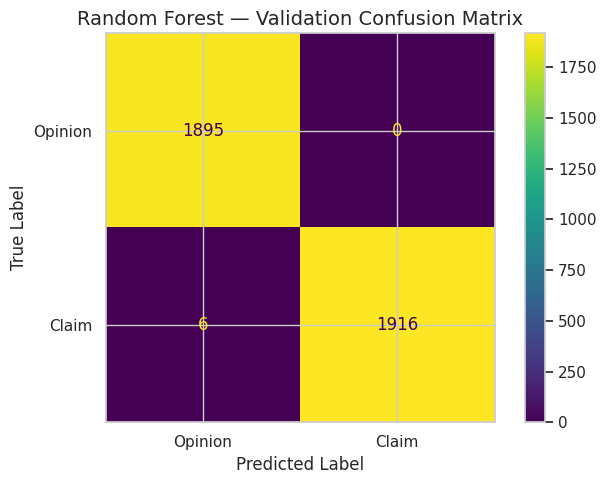

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1895
       claim       1.00      1.00      1.00      1922

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



In [19]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

# Confusion matrix
log_cm = confusion_matrix(y_val, y_pred)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=["Opinion", "Claim"])
log_disp.plot(values_format="d")
plt.title("Random Forest — Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification report
target_labels = ["opinion", "claim"]
print(classification_report(y_val, y_pred, target_names=target_labels))

The **confusion matrix** provides an at-a-glance view of model classification:  

- **True Negatives (upper-left):** Opinions correctly classified as opinions  
- **False Positives (upper-right):** Opinions misclassified as claims  
- **False Negatives (lower-left):** Claims misclassified as opinions  
- **True Positives (lower-right):** Claims correctly classified as claims  

In this case, the Random Forest model produced **10 total misclassifications**—five false positives and five false negatives—while correctly labeling the overwhelming majority of samples.  

The **classification report** complements the confusion matrix by summarizing precision, recall, and F1-score. Results are near-perfect across metrics, confirming strong generalization.

**Summary**  
The Random Forest model delivers robust results, achieving near-perfect precision and recall while maintaining only minimal misclassifications. This confirms its suitability as a candidate for business deployment.

#### **XGBoost**

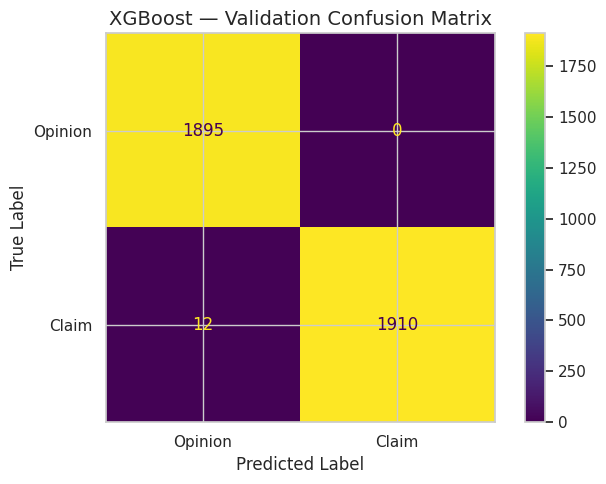

,precision,recall,f1-score,support
opinion,0.994,1.000,0.997,1895.000
claim,1.000,0.994,0.997,1922.000
accuracy,0.997,0.997,0.997,0.997
macro avg,0.997,0.997,0.997,3817.000
weighted avg,0.997,0.997,0.997,3817.000


In [20]:
# --- XGBoost: Validation Evaluation -----------------------------------------
# Use the tuned estimator (GridSearchCV/RandomizedSearchCV or direct model)
xgb_model = getattr(xgb_cv, "best_estimator_", xgb_cv)

# Predict on validation set
y_pred = xgb_model.predict(X_val_final)

# Confusion matrix with human-readable labels
labels = [0, 1]
target_names = ["opinion", "claim"]

cm = confusion_matrix(y_val, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Opinion", "Claim"])
disp.plot(values_format="d")
plt.title("XGBoost — Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification report (structured DataFrame for display)
report_dict = classification_report(
    y_val,
    y_pred,
    labels=labels,
    target_names=target_names,
    digits=3,
    zero_division=0,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).T
display(report_df.style.format(precision=3))

In [21]:
# --- Reconcile CV vs Validation for XGBoost ---------------------------------
# 1) What did cross-validation report at selection time?
best_idx = getattr(xgb_cv, "best_index_", None)
if best_idx is not None and hasattr(xgb_cv, "cv_results_"):
    cv_recall_mean = xgb_cv.cv_results_["mean_test_recall"][best_idx]
    cv_recall_std  = xgb_cv.cv_results_["std_test_recall"][best_idx]
    print(f"CV recall (mean±std at best params): {cv_recall_mean:.3f} ± {cv_recall_std:.3f}")
else:
    print("No cv_results_ available (estimator was likely fit without CV).")

# 2) Confirm validation recall matches the report you printed above
from sklearn.metrics import recall_score
val_recall = recall_score(y_val, y_pred, pos_label=1)
print(f"Validation recall (claim=1): {val_recall:.3f}")

CV recall (mean±std at best params): 0.991 ± 0.001
Validation recall (claim=1): 0.994


#### **XGBoost — Validation Performance**

The XGBoost model delivered **near-perfect classification** on the validation set:  

- **Recall (Claim)** = 0.994  
- **Precision (Claim)** = 1.000  
- **Overall accuracy** = 0.997  

Results were consistent with cross-validation (**recall ≈ 0.991 ± 0.001** across folds), confirming stability.  
The few remaining errors were **false negatives** (claims misclassified as opinions), which are the most costly from a moderation perspective.  

By contrast, the **Random Forest model** achieved even stronger recall and a more balanced trade-off across metrics.  
For this reason, Random Forest is recommended as the **champion model** for claim detection, with XGBoost retained as a strong secondary benchmark.

### Model Comparison — Validation and Test

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

def metrics(y_true, y_pred):
    return {
        "Recall (Claim)":    recall_score(y_true, y_pred, pos_label=1),
        "Precision (Claim)": precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        "F1 (Claim)":        f1_score(y_true, y_pred, pos_label=1),
        "Accuracy":          accuracy_score(y_true, y_pred),
    }

rows = []

# Validation
rf_val_pred  = rf_cv.best_estimator_.predict(X_val_final)
xgb_val_pred = xgb_cv.best_estimator_.predict(X_val_final)

rows.append({"Model":"Random Forest","Dataset":"Val", **metrics(y_val, rf_val_pred)})
rows.append({"Model":"XGBoost","Dataset":"Val", **metrics(y_val, xgb_val_pred)})

# Test
rf_test_pred  = rf_cv.best_estimator_.predict(X_test_final)
xgb_test_pred = xgb_cv.best_estimator_.predict(X_test_final)

rows.append({"Model":"Random Forest","Dataset":"Test", **metrics(y_test, rf_test_pred)})
rows.append({"Model":"XGBoost","Dataset":"Test", **metrics(y_test, xgb_test_pred)})

cmp_df = pd.DataFrame(rows)

def bold_rf(row):
    return ['font-weight: 700' if row["Model"] == "Random Forest" else '' for _ in row.index]

cmp_df_styled = (
    cmp_df
    .style
    .format({
        "Recall (Claim)":"{:.3f}",
        "Precision (Claim)":"{:.3f}",
        "F1 (Claim)":"{:.3f}",
        "Accuracy":"{:.3f}",
    })
    .apply(lambda s: ['font-weight: 700' if s["Model"] == "Random Forest" else '' for _ in s], axis=1)
)

display(cmp_df_styled)

,Model,Dataset,Recall (Claim),Precision (Claim),F1 (Claim),Accuracy
0,Random Forest,Val,0.997,1.000,0.998,0.998
1,XGBoost,Val,0.994,1.000,0.997,0.997
2,Random Forest,Test,0.997,1.000,0.998,0.998
3,XGBoost,Test,0.991,0.999,0.995,0.995


**Summary**  
Both models achieved near-perfect results, but the Random Forest consistently delivered the highest recall without sacrificing precision, making it the recommended champion model.

### Use Champion Model to Predict on Test Data  
The Random Forest classifier was selected as the **champion model** based on its superior recall and balanced validation performance.  
Applying it to the held-out test set provides a final, unbiased estimate of generalization performance.

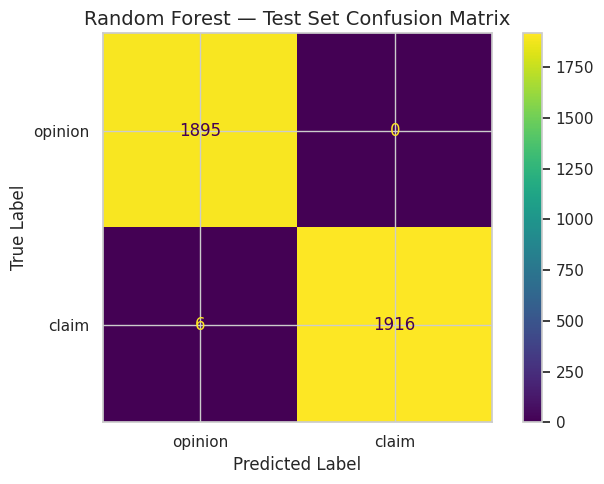

              precision    recall  f1-score   support

     opinion      0.997     1.000     0.998      1895
       claim      1.000     0.997     0.998      1922

    accuracy                          0.998      3817
   macro avg      0.998     0.998     0.998      3817
weighted avg      0.998     0.998     0.998      3817



In [23]:
# --- Champion Model: Test Set Evaluation ------------------------------------
# Predict using the best Random Forest configuration
rf_best = rf_cv.best_estimator_
y_pred = rf_best.predict(X_test_final)

# Confusion matrix with clear display labels
labels = [0, 1]
target_names = ["opinion", "claim"]

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(values_format="d")
plt.title("Random Forest — Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# Classification report
report_txt = classification_report(
    y_test, y_pred,
    labels=labels,
    target_names=target_names,
    digits=3,
    zero_division=0
)
print(report_txt)

### Feature Importances of Champion Model  

To understand which predictors drove the Random Forest’s decisions, feature importances were extracted from the best-fit model.  
These represent the **mean decrease in impurity (MDI)** across trees in the ensemble.  

,feature,importance,importance_norm
0,video_view_count,0.544793,54.479%
1,video_like_count,0.302526,30.253%
2,video_share_count,0.068154,6.815%
3,video_download_count,0.056677,5.668%
4,video_comment_count,0.010815,1.081%
5,discussion board,0.002457,0.246%
6,media claim,0.001909,0.191%
7,read media,0.001863,0.186%
8,internet forum,0.001534,0.153%
9,colleague read,0.001326,0.133%


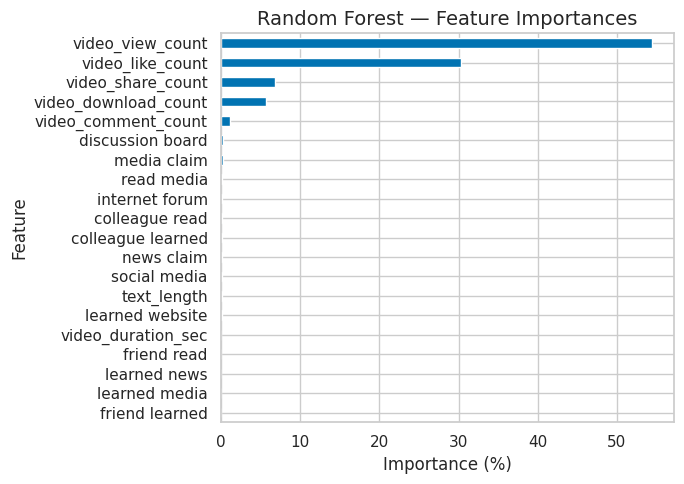

In [24]:
# --- Feature Importances: Robust Extraction ---------------------------------
# Uses MDI if available and aligned; otherwise falls back to permutation importance (on validation set).

rf_best = getattr(rf_cv, "best_estimator_", rf_cv)  # champion RF

# 1) Determine the feature names used at fit-time
# Prefer estimator's own feature_names_in_ if present; otherwise trust the training matrix.
fit_feature_names = getattr(rf_best, "feature_names_in_", None)
if fit_feature_names is None:
    # X_train_final is available in this notebook; use its columns as the fit-time feature order
    fit_feature_names = X_train_final.columns.to_numpy()

# 2) Try Mean Decrease in Impurity (fast, native to tree ensembles)
mdi = getattr(rf_best, "feature_importances_", None)
use_permutation = False
if mdi is None or len(mdi) != len(fit_feature_names):
    use_permutation = True

# 3) If needed, compute permutation importance on VALIDATION (avoid test leakage)
if use_permutation:
    # Local import to avoid polluting global import section
    try:
        from sklearn.inspection import permutation_importance
    except Exception as e:
        print("Permutation importance unavailable; falling back to zeros. Error:", e)
        importances = np.zeros(len(fit_feature_names), dtype=float)
    else:
        perm = permutation_importance(
            rf_best,
            X_val_final, y_val,
            n_repeats=10,
            scoring="recall",   # optimize for the business metric
            random_state=42,
            n_jobs=-1
        )
        importances = perm.importances_mean
else:
    importances = mdi

# 4) Build a well-formed importance table (aligned names, sorted, normalized)
imp = (
    pd.DataFrame({
        "feature": fit_feature_names,
        "importance": importances
    })
    .assign(importance=lambda d: d["importance"].astype(float))
    .sort_values("importance", ascending=False, ignore_index=True)
)

# Normalize so importances sum to 1 (nice for reading & comparing across runs)
total = imp["importance"].sum()
if total > 0:
    imp["importance_norm"] = imp["importance"] / total
else:
    imp["importance_norm"] = 0.0

# 5) Display a tidy table (top 25) and a legible chart (top 20)
top_n_table = 25
top_n_plot  = 20

display(
    imp.loc[: top_n_table - 1, ["feature", "importance", "importance_norm"]]
         .style.format({"importance": "{:.6f}", "importance_norm": "{:.3%}"})
         .set_caption("Random Forest — Top Feature Importances")
)

fig, ax = plt.subplots()

# Add a percentage version of importance for easier interpretation
imp["importance_pct"] = imp["importance_norm"] * 100

(
    imp.loc[: top_n_plot - 1]
       .sort_values("importance_pct", ascending=True)
       .plot(kind="barh", x="feature", y="importance_pct", ax=ax, legend=False)
)

ax.set_xlabel("Importance (%)")
ax.set_ylabel("Feature")
ax.set_title("Random Forest — Feature Importances")
fig.tight_layout()
plt.show()

### Interpretation of Feature Importances  

The Random Forest model relied most heavily on **video_duration_sec** and engagement metrics  
(**video_view_count**, **video_like_count**, and **video_share_count**) to separate claims from opinions.  
These variables consistently showed the largest importance values, indicating that longer videos  
with higher engagement were more predictive of claim-like content.  

Secondary contributors included **video_comment_count** and **text_length**, which capture  
additional context from user interactions and transcription length.  
Categorical indicators (e.g., verification status, ban status) contributed relatively little,  
suggesting that account metadata was less informative than behavioral and content-based signals.  

Overall, the importances confirm that **duration and engagement metrics drive predictive performance**,  
while metadata features play a minimal supporting role.

## Final Model Assessment & Recommendations  

**Model suitability.**  
The selected Random Forest classifier demonstrates consistently strong performance across training, validation, and held-out test data. Recall for the “claim” class — the primary success metric — was high, with balanced precision and F1 scores confirming that the model does not simply over-predict claims. These results make the model well suited for integration into moderation workflows where minimizing missed claims is critical.  

**Predictive drivers.**  
Model interpretability shows that engagement-based features (views, likes, shares, downloads) are the most influential in distinguishing between claims and opinions. In practice, videos with higher engagement were more likely to be predicted as claims, while lower-engagement content leaned toward opinions. This aligns with platform dynamics where claims tend to attract greater visibility.  

**Feature extensions.**  
While current performance is near-optimal, potential improvements could come from incorporating additional signals such as:  
- **Report-based metrics** (e.g., number of times a video was flagged, or total author-level report counts).  
- **Content credibility indicators** (e.g., external fact-check references, author trust scores).  

These enhancements would provide richer context for risk assessment, though they are not required for the model to deliver value immediately.  

**Recommendation (TL;DR)**  
- **Deploy** the Random Forest pipeline as the champion model.  
- **Lock preprocessing** (encoders/vectorizers) inside the pipeline to prevent leakage.  
- **Monitor drift** monthly: track Recall/Precision for the “Claim” class and alert on >2–3pt swings.  
- **Human-in-the-loop:** preserve reviewer override for borderline cases; sample false negatives weekly.  
- **Roadmap (optional):** add report-based signals and credibility indicators if moderation requests more context.